In [96]:
import pandas as pd

In [97]:
crime = pd.read_csv("crime_weather_preprocessed")
print(crime.columns)
print(crime.shape[0])

Index(['dow', 'hour_of_day', 'offense_date', 'temp_max', 'temp_min',
       'daylight_duration', 'precipitation_sum', 'precipitation_hours',
       'extracted_month', 'extracted_day', 'ucr_desc_numeric',
       'offense_year_numeric', 'time_block_numeric', 'census_tract_numeric',
       'census_block_numeric'],
      dtype='object')
360042


In [98]:
crime['offense_date'] = pd.to_datetime(crime['offense_date'], errors='coerce')

crime.set_index('offense_date', inplace=True)

In [99]:
crime_time_series = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).agg({
    'dow': 'mean',  
    'hour_of_day': 'mean',
    'extracted_month': 'mean',
    'extracted_day': 'mean',
    'temp_max': 'mean',
    'temp_min': 'mean',
    'daylight_duration': 'mean',
    'precipitation_sum': 'mean',
    'precipitation_hours': 'mean',
    'time_block_numeric': 'mean'
}).reset_index()

crime_time_series['Crime_Count_W'] = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).size().values

crime_time_series = crime_time_series.drop(columns=['offense_date'])

crime_time_series

,census_block_numeric,dow,hour_of_day,extracted_month,extracted_day,temp_max,temp_min,daylight_duration,precipitation_sum,precipitation_hours,time_block_numeric,Crime_Count_W
0,0,3.612903,10.774194,1.000000,3.419355,14.012673,2.872995,33396.085874,0.036132,8.258065,1.225806,62
1,0,3.931818,13.840909,1.000000,10.727273,39.481495,25.380132,33891.959251,0.225304,8.454545,1.000000,44
2,0,3.800000,14.171429,1.000000,18.028571,33.977197,18.672054,34573.083036,0.036670,4.057143,0.800000,35
3,0,4.017857,12.696429,1.000000,24.625000,46.487669,32.168027,35307.395717,0.092238,7.750000,1.178571,56
4,0,4.780488,11.317073,1.658537,11.878049,33.318698,17.041868,36302.567645,0.059823,7.024390,1.268293,41
...,...,...,...,...,...,...,...,...,...,...,...,...
33332,239,4.000000,0.000000,7.000000,13.000000,79.916000,63.986000,53716.195312,0.051181,4.000000,3.000000,1
33333,239,1.000000,7.500000,7.000000,31.000000,83.606003,61.916000,51864.425781,0.000000,0.000000,1.500000,2
33334,239,5.000000,17.000000,9.000000,29.000000,57.866001,44.456001,42640.847656,0.031496,4.000000,0.000000,1
33335,239,5.000000,0.000000,12.000000,1.000000,33.206001,24.746000,33854.109375,0.007874,2.000000,3.000000,1


In [100]:
crime_time_series.columns

Index(['census_block_numeric', 'dow', 'hour_of_day', 'extracted_month',
       'extracted_day', 'temp_max', 'temp_min', 'daylight_duration',
       'precipitation_sum', 'precipitation_hours', 'time_block_numeric',
       'Crime_Count_W'],
      dtype='object')

In [101]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def k_fold_cross_validation(model, X, y, k=5, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    fold_metrics = []

    mae_list, rmse_list, r2_list = [], [], []
    all_y_test = [] 
    all_y_pred = []

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"Fold {fold + 1} Metrics:")
        print(f"  Mean Absolute Error (MAE): {mae}")
        print(f"  Root Mean Squared Error (RMSE): {rmse}")
        print(f"  R² Score: {r2}\n")

        fold_metrics.append((mae, rmse, r2))

    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)
    avg_r2 = np.mean(r2_list)

    print(f"Average MAE across {k} folds: {avg_mae}")
    print(f"Average RMSE across {k} folds: {avg_rmse}")
    print(f"Average R² Score across {k} folds: {avg_r2}")

    plt.figure(figsize=(12, 8))
    plt.plot(all_y_test, label='Actual Crime Count', color='blue')
    plt.plot(all_y_pred, label='Predicted Crime Count', linestyle='--', color='red')
    plt.legend()
    plt.title(f'Actual vs. Predicted Crime Count (Weekly) - Comprehensive Plot Across {k} Folds')
    plt.xlabel('Combined Test Samples from All Folds')
    plt.ylabel('Crime Count')
    plt.show()

    return avg_mae, avg_rmse, avg_r2, fold_metrics

In [102]:
features = ['census_block_numeric', 'dow', 'hour_of_day', 'extracted_month', 
            'extracted_day', 'temp_max', 'temp_min', 'daylight_duration', 
            'precipitation_sum', 'precipitation_hours', 'time_block_numeric']
X = crime_time_series[features]
y = crime_time_series['Crime_Count_W']

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 Metrics:
  Mean Absolute Error (MAE): 2.7248035392921413
  Root Mean Squared Error (RMSE): 4.5061835389809195
  R² Score: 0.8900716186061632



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 Metrics:
  Mean Absolute Error (MAE): 2.6929124175164967
  Root Mean Squared Error (RMSE): 4.512534163536557
  R² Score: 0.894462123943491



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 Metrics:
  Mean Absolute Error (MAE): 2.6667646617669116
  Root Mean Squared Error (RMSE): 4.429530798272585
  R² Score: 0.8958417326780777



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 Metrics:
  Mean Absolute Error (MAE): 2.7127463626818655
  Root Mean Squared Error (RMSE): 4.432888437013191
  R² Score: 0.8957087423697819



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 Metrics:
  Mean Absolute Error (MAE): 2.7167721613919307
  Root Mean Squared Error (RMSE): 4.509961994533922
  R² Score: 0.8966550535517848

Average MAE across 5 folds: 2.7027998285298693
Average RMSE across 5 folds: 4.4782197864674345
Average R² Score across 5 folds: 0.8945478542298598


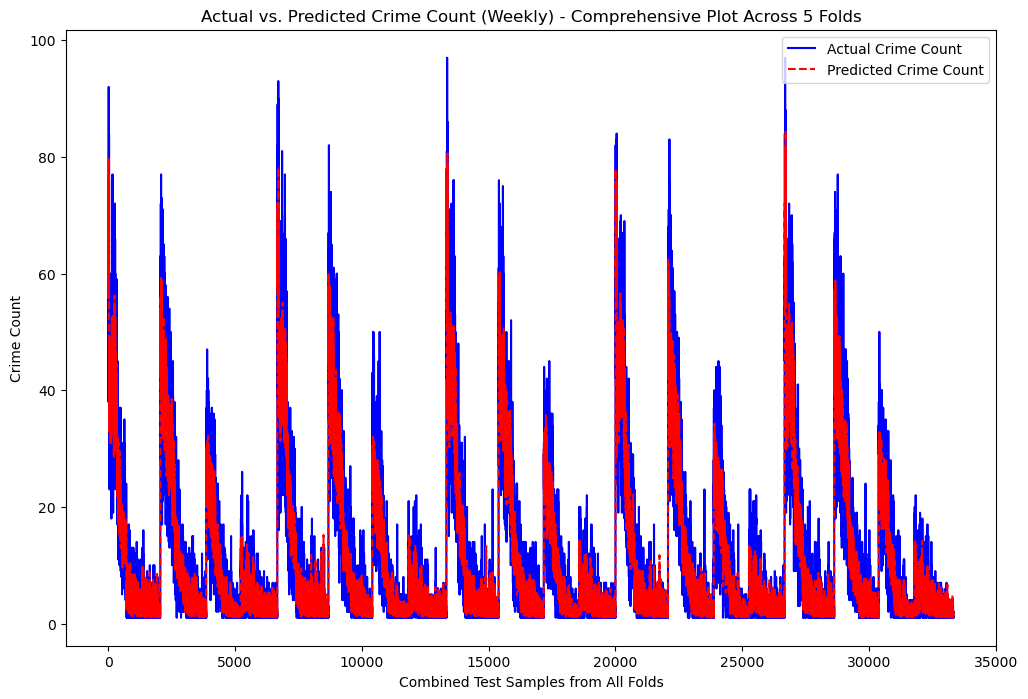

In [103]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
avg_mae, avg_rmse, avg_r2, metrics = k_fold_cross_validation(rf_model, X, y)

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 Metrics:
  Mean Absolute Error (MAE): 2.5958013282435144
  Root Mean Squared Error (RMSE): 4.359450401159542
  R² Score: 0.8971141576766968



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 Metrics:
  Mean Absolute Error (MAE): 2.5941304820315967
  Root Mean Squared Error (RMSE): 4.431130924064588
  R² Score: 0.8982354402542114



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 Metrics:
  Mean Absolute Error (MAE): 2.576657363327447
  Root Mean Squared Error (RMSE): 4.319309935608491
  R² Score: 0.9009608030319214



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 Metrics:
  Mean Absolute Error (MAE): 2.5824349859510933
  Root Mean Squared Error (RMSE): 4.233474705200084
  R² Score: 0.9048807621002197



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 Metrics:
  Mean Absolute Error (MAE): 2.6213048980496594
  Root Mean Squared Error (RMSE): 4.440972214493981
  R² Score: 0.8997926712036133

Average MAE across 5 folds: 2.594065811520662
Average RMSE across 5 folds: 4.356867636105338
Average R² Score across 5 folds: 0.9001967668533325


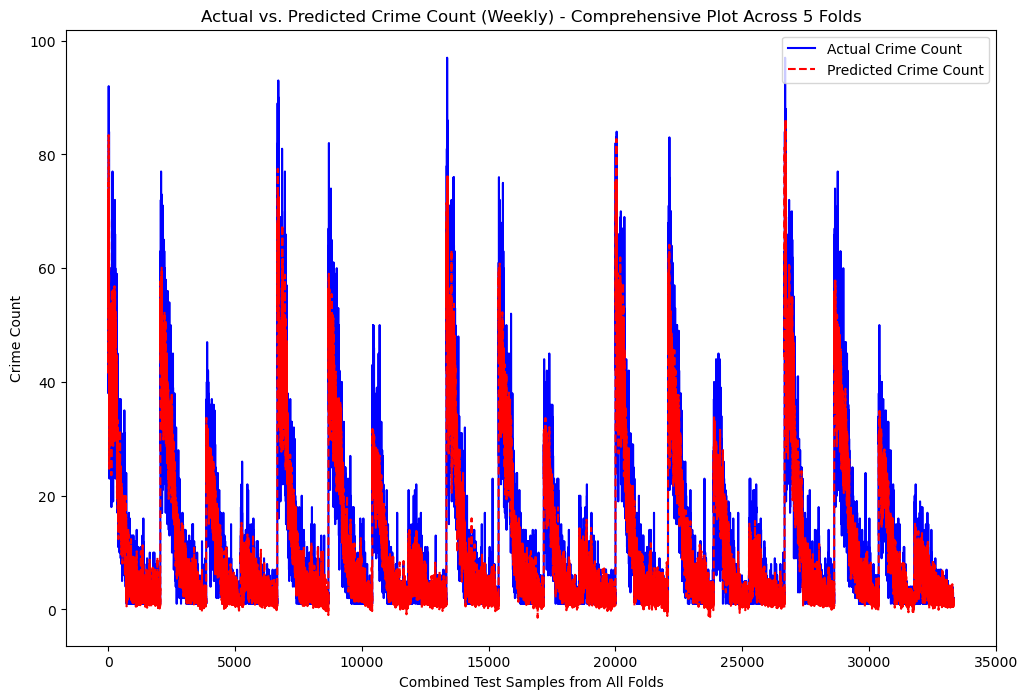

In [104]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)
avg_mae, avg_rmse, avg_r2, metrics = k_fold_cross_validation(xgb_model, X, y)

In [109]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

timesteps = 24  
features = ['census_block_numeric', 'dow', 'hour_of_day', 'extracted_month', 'extracted_day', 'temp_max', 
            'temp_min', 'daylight_duration', 'precipitation_sum', 'precipitation_hours', 
            'time_block_numeric']
target = 'Crime_Count_W'

scaler = MinMaxScaler()
crime_time_series[features] = scaler.fit_transform(crime_time_series[features])

X = crime_time_series[features].values
y = crime_time_series[target].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_generator = TimeseriesGenerator(X_train, y_train, length=timesteps, batch_size=64)
val_generator = TimeseriesGenerator(X_val, y_val, length=timesteps, batch_size=64)

X_transformed, y_transformed = train_generator[0]

X_train shape (samples, timesteps, features): (64, 24, 11)
y_train shape (samples,): (64,)


Epoch 1/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 58s 118ms/step - loss: 9.4752 - val_loss: 8.8903 - learning_rate: 5.0000e-04
Epoch 2/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - loss: 8.9338 - val_loss: 8.7498 - learning_rate: 5.0000e-04
Epoch 3/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 48s 115ms/step - loss: 8.9077 - val_loss: 8.7265 - learning_rate: 5.0000e-04
Epoch 4/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 55s 131ms/step - loss: 8.9003 - val_loss: 8.7485 - learning_rate: 5.0000e-04
Epoch 5/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 62s 148ms/step - loss: 8.7775 - val_loss: 8.7491 - learning_rate: 5.0000e-04
Epoch 6/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 73s 175ms/step - loss: 8.9246 - val_loss: 8.6799 - learning_rate: 5.0000e-04
Epoch 7/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 74s 178ms/step - loss: 8.9913 - val_loss: 8.6688 - learning_rate: 5.0000e-04
Epoch 8/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 75s 179ms/step - loss: 8.7126 - val_loss: 8.7767 - learning_rate: 5.0000e-04
Epoch 9/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 75s 181ms/step - loss: 8

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error: 8.625929489615164
Root Mean Squared Error: 14.92719067690245
R² Score: -0.20388567447662354


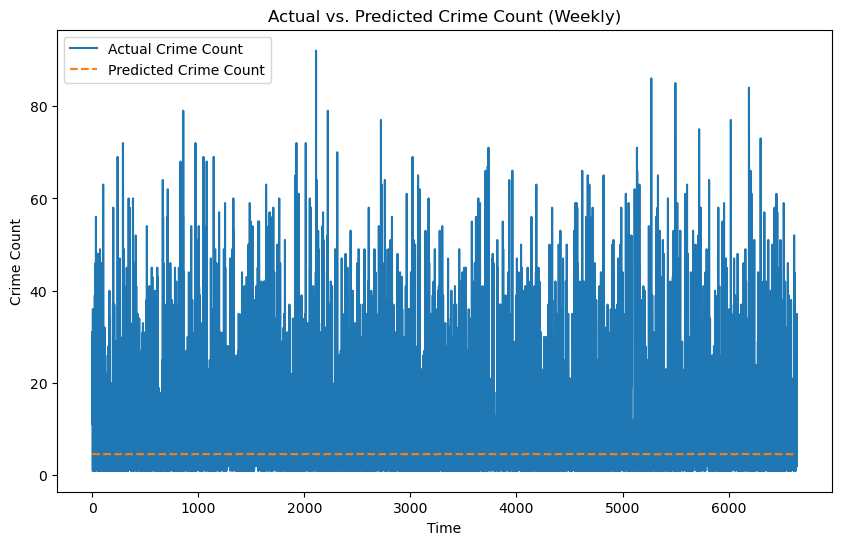

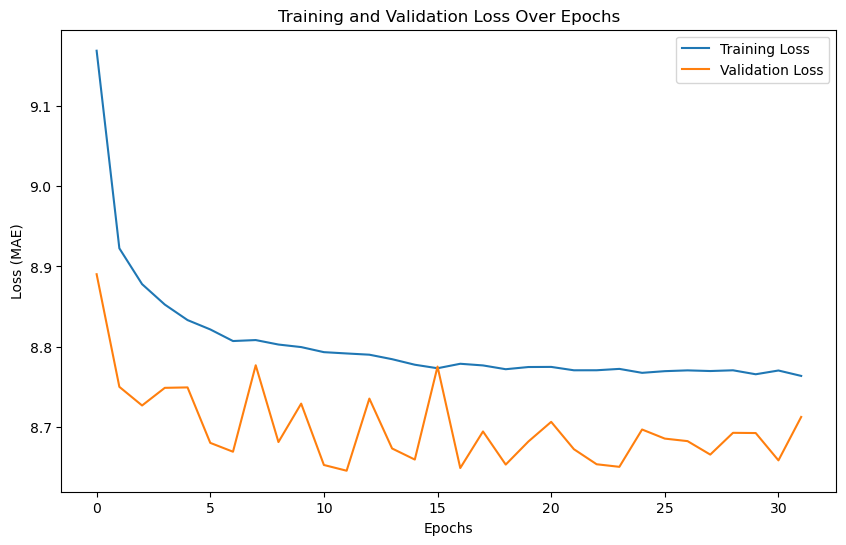

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def build_model(input_shape):
    model = Sequential([

        LSTM(256, activation='relu', return_sequences=True, input_shape=input_shape,
             kernel_regularizer=l2(0.001)),
        Dropout(0.4),

        LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.4),

        GRU(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        GRU(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1)  
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mae')
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

input_shape = (timesteps, X_train.shape[1])  # timesteps, features
advanced_model = build_model(input_shape)

history = advanced_model.fit(
    train_generator, 
    epochs=50, 
    validation_data=val_generator, 
    callbacks=[early_stopping, reduce_lr]
)

y_pred = advanced_model.predict(val_generator).flatten()

mae = mean_absolute_error(y_val[timesteps:], y_pred)
rmse = mean_squared_error(y_val[timesteps:], y_pred, squared=False)
r2 = r2_score(y_val[timesteps:], y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

plt.figure(figsize=(10, 6))
plt.plot(y_val[timesteps:], label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Weekly)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.show()

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def build_rnn_model(input_shape):
    model = Sequential([

        SimpleRNN(256, activation='relu', input_shape=input_shape, return_sequences=True, 
                  kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        
        SimpleRNN(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        
        SimpleRNN(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        SimpleRNN(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1) 
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='mae')
    return model

input_shape = (X_transformed.shape[1], X_transformed.shape[2])
rnn_model = build_rnn_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=64, 
                        validation_data=(X_val, y_val), verbose=1, 
                        callbacks=[reduce_lr, early_stopping])

y_pred = rnn_model.predict(X_val).flatten()

mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Weekly)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.show()

C:\Users\singh\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 11), dtype=float32). Expected shape (None, 24, 11), but input has incompatible shape (None, 11)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 11), dtype=float32)
  • training=True
  • mask=None